# <p style="text-align: center;">Bus delay prediction</p>

# Introduction

### Background:
Bus services are highly sensitive to delays caused by traffic congestion, passenger boarding times, and disruptions along the route. Predicting delays accurately can help transport operators improve service reliability, design real-time control strategies, and provide passengers with accurate arrival information.

### Task relevance:
- Delays are continuous outcomes (measured in seconds), making regression an appropriate modeling approach.
- High predictive performance can directly support intelligent transport systems (ITS), improving efficiency and passenger satisfaction.

### Dataset
The dataset is collected for predicting arrival delays at one bus stop. It contains historical information on buses at the bus stop Linnégatan on the high-frequency inner-city bus line 1 in Stockholm, Sweden, shown in Fig. 1. The line is characterized by frequent service, articulated vehicles, dedicated lanes on major roads, and real-time information displays at every stop. The selected bus stop is in the middle of the line. For analysis purposes, data on bus arrival delays during May 2022 was collected. Specifically, data was gathered from 6:00 a.m. to 10:00 p.m., covering the operational hours of the bus service.

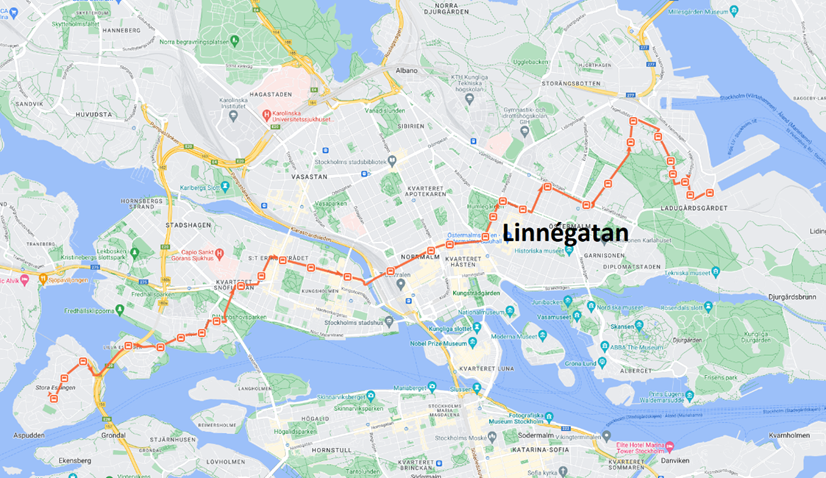

### Basic Information:

- **Arrival_time**: Indicates the specific time of the stop.
- **stop_id**: Indicates the id of the stop station.
- **Bus_id**: Indicates the id of current bus/vehicle.
- **Line_id**: Indicates the id of the line the bus belongs to.

### Operation information:

- **arrival_delay**: The arrival delay of the bus at the stop, that is the difference between the actual arrival time and the scheduled arrival time of the bus at the stop.
- **dwell_time**: Actual dwell time at the consecutive upstream stop, that is the difference between the actual departure time and the actual arrival time of the bus at the consecutive upstream stop (i.e., the first previous stop)
- **scheduled_travel_time**: Scheduled running time between the stop and its first previous stop, that is the difference between scheduled arrival time at the stop and the scheduled departure time at first previous station.
- **upstream_stop_delay**: Actual arrival delay of bus at the upstream stop, that is the difference between the actual and scheduled arrival time at the upstream stop.
- **recurrent_delay**: Recurrent delays, that is the historical mean for the travel time of the bus at the stop during the same hour in the same weekdays. It captures the -recurring bus delays observed at current stop during this time period.

## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Data Loading 

In [2]:
df_bus = pd.read_csv('Exercise2BusData.csv')

In [3]:
df_bus.head()

,Arrival_time,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
0,01/05/2022 07:03,10033,41355,1,-23,0,39,-4,28.641509
1,01/05/2022 07:21,10033,41356,1,168,0,39,181,27.880597
2,01/05/2022 07:37,10033,44400,1,231,0,39,244,27.852941
3,01/05/2022 07:50,10033,44399,1,150,17,39,143,27.826087
4,01/05/2022 19:29,10033,44060,1,965,35,51,947,42.029412


In [4]:
df_bus.info() 
df_bus.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Arrival_time           2179 non-null   object 
 1   Stop_id                2179 non-null   int64  
 2   Bus_id                 2179 non-null   int64  
 3   Line_id                2179 non-null   int64  
 4   Arrival_delay          2179 non-null   int64  
 5   Dwell_time             2179 non-null   int64  
 6   Scheduled_travel_time  2179 non-null   int64  
 7   Upstream_stop_delay    2179 non-null   int64  
 8   Recurrent_delay        2179 non-null   float64
dtypes: float64(1), int64(7), object(1)
memory usage: 153.3+ KB


,Stop_id,Bus_id,Line_id,Arrival_delay,Dwell_time,Scheduled_travel_time,Upstream_stop_delay,Recurrent_delay
count,2179.0,2179.000000,2179.0,2179.000000,2179.000000,2179.000000,2179.000000,2179.000000
mean,10033.0,42255.504819,1.0,216.376319,27.023405,58.164296,200.402478,45.972240
std,0.0,1246.205733,0.0,181.194381,14.103575,7.008233,177.460222,6.517437
min,10033.0,41343.000000,1.0,-72.000000,0.000000,39.000000,-82.000000,27.605263
25%,10033.0,41358.000000,1.0,89.000000,19.000000,51.000000,77.000000,39.390890
50%,10033.0,41373.000000,1.0,175.000000,25.000000,62.000000,159.000000,48.671756
75%,10033.0,44059.000000,1.0,292.000000,33.000000,62.000000,275.500000,50.940968
max,10033.0,45917.000000,1.0,1365.000000,132.000000,103.000000,1364.000000,54.492647


Note : No missing data, 'Stop_id' and 'Line_id' have an unique value. There is probably no difference between the performance of the busses but we'll check on this later

In [5]:
to_remove = ['Stop_id', 'Line_id']
df_bus = df_bus.drop(columns=to_remove)

In [6]:
df_bus['Arrival_time'] = pd.to_datetime(df_bus['Arrival_time'], format='%d/%m/%Y %H:%M')
df_bus['Hour'] = df_bus['Arrival_time'].dt.hour
df_bus['Weekday'] = df_bus['Arrival_time'].dt.dayofweek
df_bus = df_bus.drop(columns=['Arrival_time'])


In [7]:
corr_matrix = df_bus.corr()
corr_matrix['Arrival_delay'].sort_values(ascending=False)

Arrival_delay            1.000000
Upstream_stop_delay      0.993935
Dwell_time               0.218745
Recurrent_delay          0.162692
Scheduled_travel_time    0.100695
Hour                     0.058081
Weekday                  0.049933
Bus_id                   0.002019
Name: Arrival_delay, dtype: float64

As expected, the model of bus used does not affect the delay (<0.01). We can then remove the 'Bus_id' feature.

In [8]:
df_bus = df_bus.drop(columns=['Bus_id'])

## Normalization

In [9]:
sc = StandardScaler()
df_bus_std = sc.fit_transform(df_bus)

In [10]:
df_bus_std 

array([[-1.32140558, -1.91650752, -2.73516807, ..., -2.65974322,
        -1.66291307,  1.5273462 ],
       [-0.26704704, -1.91650752, -2.73516807, ..., -2.77652027,
        -1.66291307,  1.5273462 ],
       [ 0.08072567, -1.91650752, -2.73516807, ..., -2.7807646 ,
        -1.66291307,  1.5273462 ],
       ...,
       [-0.71970359, -0.28534103, -1.02250314, ..., -1.62027336,
         1.53119511, -0.98669472],
       [-0.52649653, -1.2073047 , -1.02250314, ..., -1.62658713,
         1.53119511, -0.98669472],
       [ 1.4386953 , -0.4271816 , -1.02250314, ..., -1.61265335,
         1.75934569, -0.98669472]])

In [11]:
x_bus = df_bus.drop(columns=['Arrival_delay'])
y_bus = df_bus['Arrival_delay']

/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/sebastienlemasne/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and

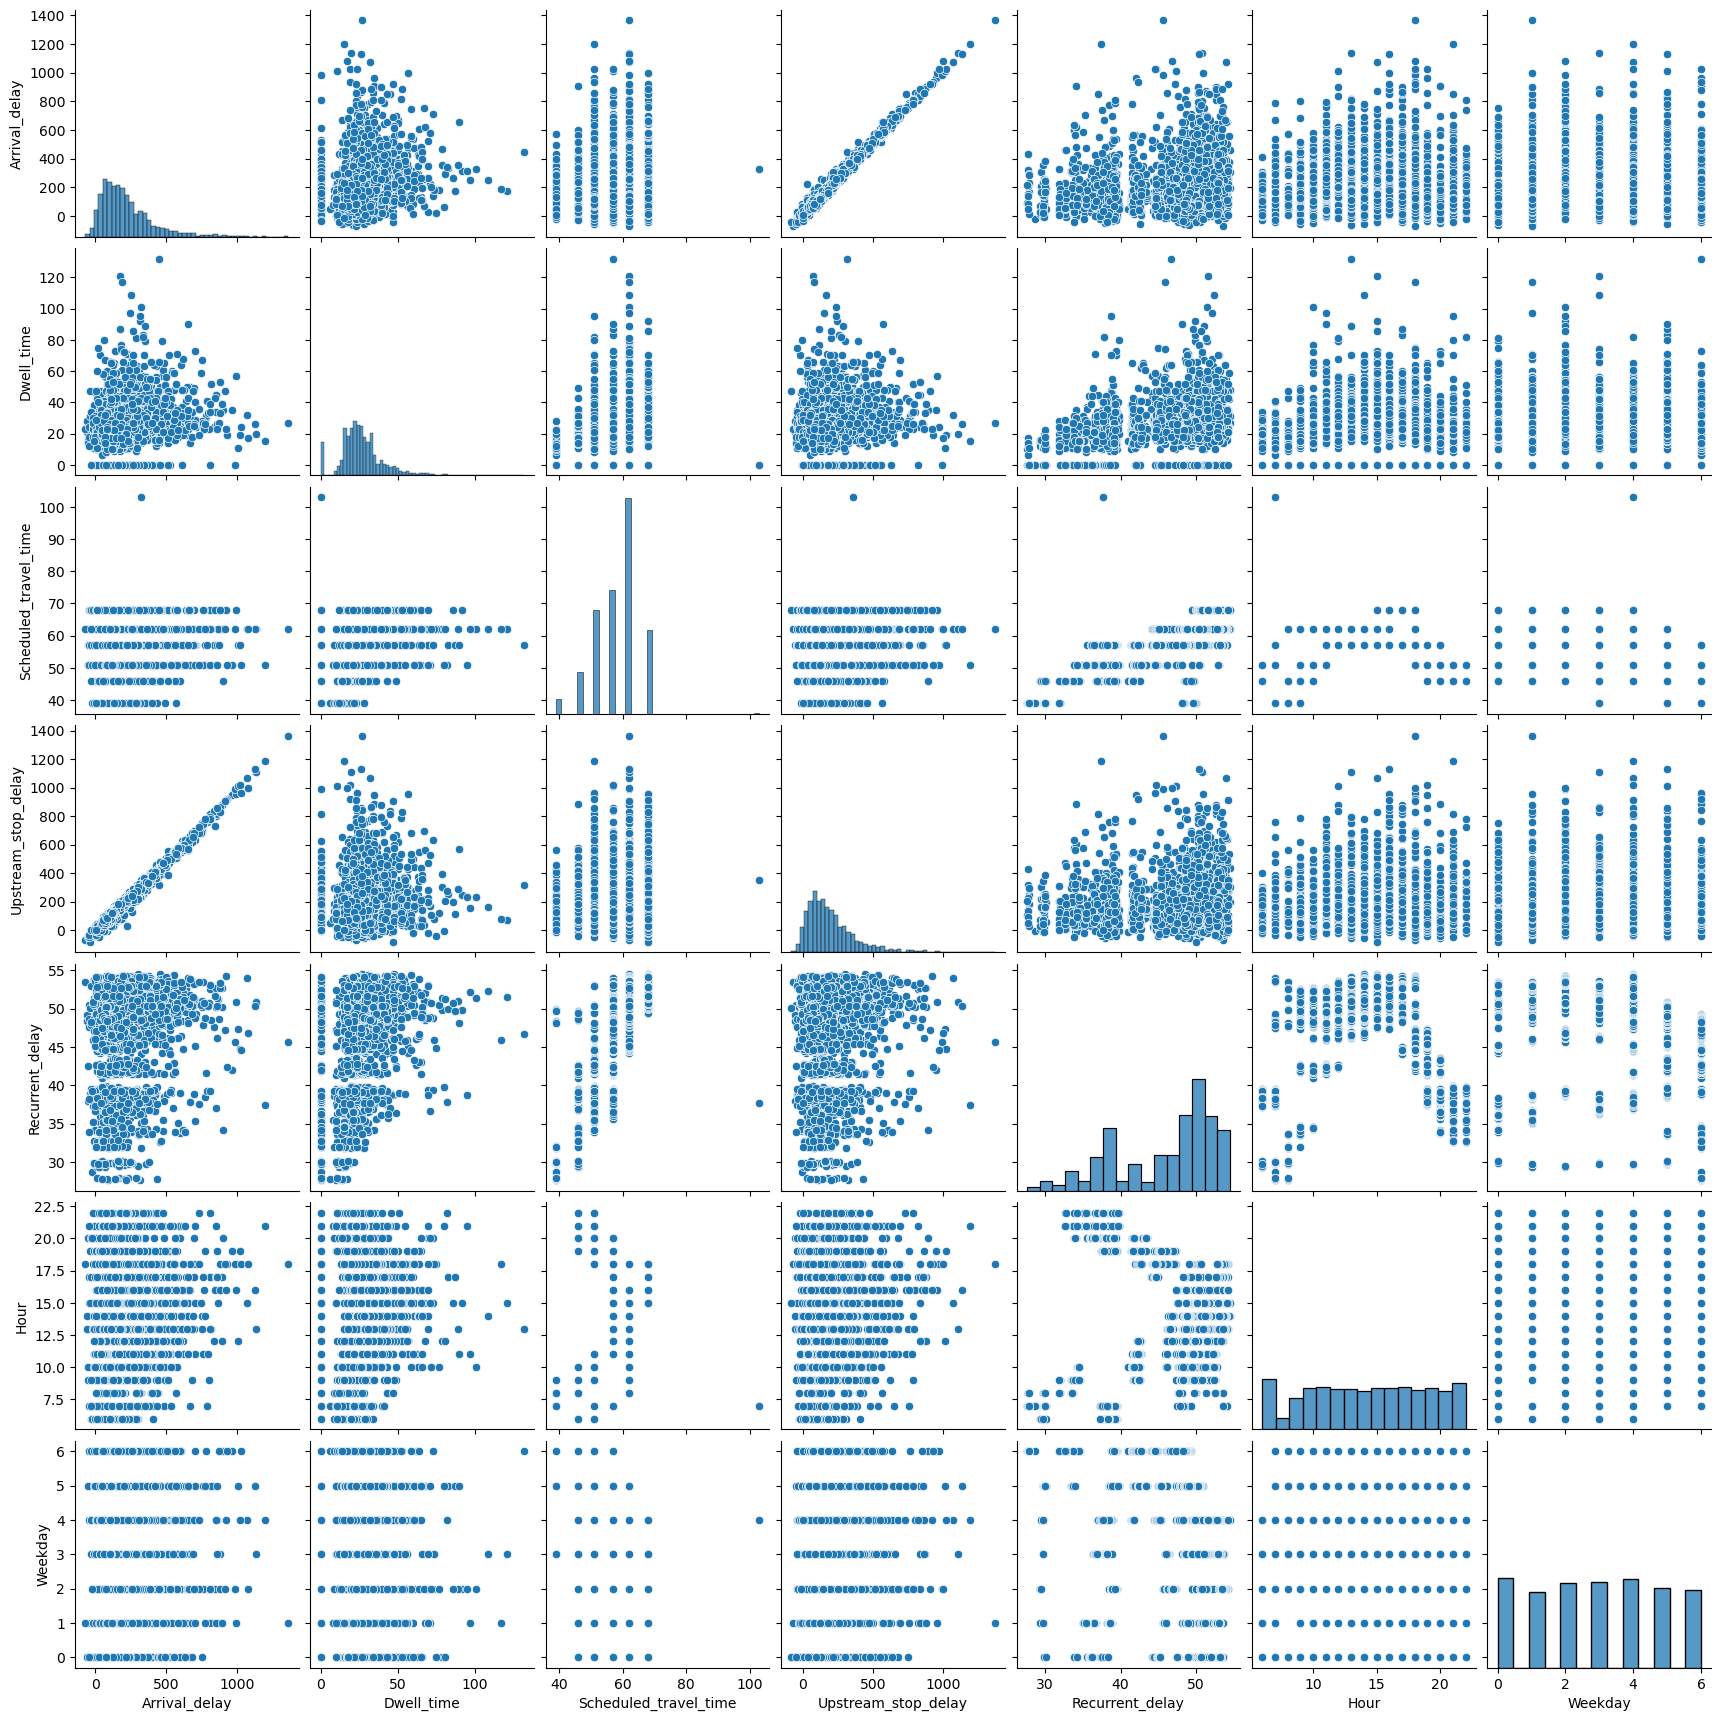

In [12]:
sns.pairplot(df_bus)

## Train/Test split

In [13]:
X_bus_train, X_bus_test, y_bus_train, y_bus_test = train_test_split(x_bus, y_bus, test_size=0.2, random_state=42)

## Training of the model

### Grid Search

In [14]:
param_grid = {
    'n_estimators': [5, 100, 200, 400],
    'learning_rate': [0.03, 0.1, 0.2],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [0.7, 1.0],
    'min_child_weight': [1, 3],
    'gamma': [0, 0.1]
}
xgb_model = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,             
    n_jobs=-1,
    verbose=1,
    refit=True
)

grid.fit(X_bus_train, y_bus_train)


NameError: name 'GridSearchCV' is not defined

In [36]:
print("Best hyperparameters:", grid.best_params_)
best_mse = -grid.best_score_
best_rmse = np.sqrt(best_mse)
print(f"Best MSE (CV): {best_mse:.3f}")
print(f"Best RMSE (CV): {best_rmse:.3f}")

Best hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400, 'subsample': 1.0}
Best MSE (CV): 288.770
Best RMSE (CV): 16.993


In [38]:
best_model = grid.best_estimator_
y_bus_pred = best_model.predict(X_bus_test)

In [39]:
y_bus_pred = pd.Series(y_bus_pred, index=y_bus_test.index)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

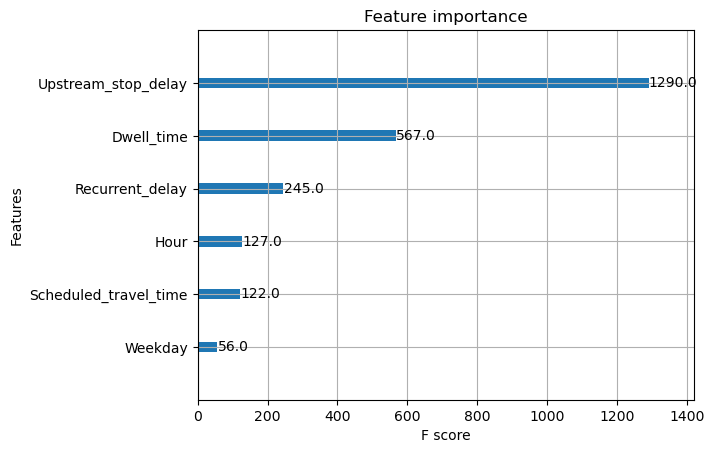

In [44]:
xgb.plot_importance(best_model)

## Metrics

In [45]:
# Calculate metrics
mse = mean_squared_error(y_bus_test, y_bus_pred)
rmse = mean_squared_error(y_bus_test, y_bus_pred, squared=False)  # Root Mean Squared Error
mae = mean_absolute_error(y_bus_test, y_bus_pred)
r2 = r2_score(y_bus_test, y_bus_pred)

# Print metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 214.7383425377465
Root Mean Squared Error (RMSE): 14.653953136875609
Mean Absolute Error (MAE): 10.769754236717837
R-squared (R2): 0.9927988383627492


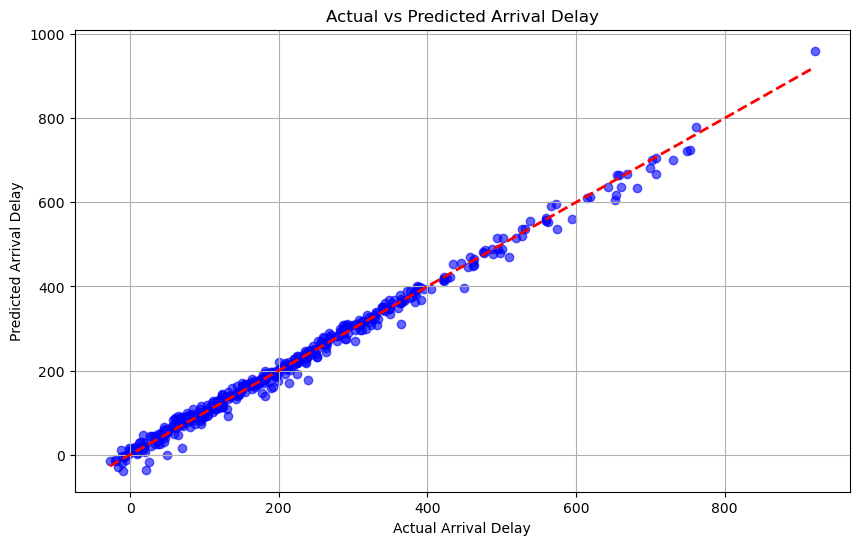

In [46]:
plt.figure(figsize=(10, 6))
plt.scatter(y_bus_test, y_bus_pred, alpha=0.6, color='b')
plt.plot([y_bus_test.min(), y_bus_test.max()], [y_bus_test.min(), y_bus_test.max()], 'r--', lw=2)
plt.xlabel('Actual Arrival Delay')
plt.ylabel('Predicted Arrival Delay')
plt.title('Actual vs Predicted Arrival Delay')
plt.grid(True)
plt.show()